## Image Generator
This code does all the following things:
- Creates images with and without ellipses.
- Saves the images arrays (.npy files).
- Saves the images (.jpg files).
- Saves a label files (labels.csv) indicating whether an image contains an ellipse (1) or not (0).

In [ ]:
import numpy as np
from PIL import Image, ImageDraw
import os
import random
import csv
from tqdm import tqdm

# Constants
IMAGE_SIZE = 8  # 8x8 pixels
NUM_IMAGES = 256  # Number of images to generate
OUTPUT_DIR = "pixel_art_dataset"  # Output directory
LABELS_FILE = os.path.join(OUTPUT_DIR, "labels.csv")  # Labels file path
GRAYSCALE_LEVELS = 8  # Number of grayscale levels

# Create output directory if it doesn't exist
os.makedirs(OUTPUT_DIR, exist_ok=True)

def create_smooth_gradient_background(size):
    """Create a smooth random gradient background."""
    corners = np.random.randint(0, GRAYSCALE_LEVELS, size=4) * (255 // (GRAYSCALE_LEVELS - 1))
    y, x = np.mgrid[0:size, 0:size] / (size - 1)
    top = corners[0] * (1 - x) + corners[1] * x
    bottom = corners[2] * (1 - x) + corners[3] * x
    gradient = top * (1 - y) + bottom * y
    return np.round(gradient).astype(np.uint8)

def add_ellipse(img_array, size):
    """Add an ellipse to the image."""
    temp_img = Image.fromarray(img_array, 'L')
    draw = ImageDraw.Draw(temp_img)
    x0, y0 = random.randint(0, size-3), random.randint(0, size-3)
    x1, y1 = x0 + random.randint(2, size//2), y0 + random.randint(2, size//2)
    fill_value = random.randint(0, GRAYSCALE_LEVELS-1) * (255 // (GRAYSCALE_LEVELS - 1))
    draw.ellipse([x0, y0, x1, y1], fill=fill_value)
    return np.array(temp_img)

def generate_pixel_art():
    """Generate images with and without ellipses and save them."""
    labels = []
    for i in tqdm(range(NUM_IMAGES)):
        img_array = create_smooth_gradient_background(IMAGE_SIZE)
        has_ellipse = random.random() < 0.5  # 50% chance
        if has_ellipse:
            img_array = add_ellipse(img_array, IMAGE_SIZE)

        # Save numpy array
        np.save(os.path.join(OUTPUT_DIR, f"pixel_art_{i:03d}.npy"), img_array)

        # Save as image
        img = Image.fromarray(img_array, 'L')
        img.save(os.path.join(OUTPUT_DIR, f"pixel_art_{i:03d}.jpg"), quality=100)

        # Store label
        labels.append([f"pixel_art_{i:03d}.jpg", int(has_ellipse)])

    # Save labels to CSV
    with open(LABELS_FILE, mode='w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(["filename", "label"])  # Header
        writer.writerows(labels)

if __name__ == "__main__":
    print(f"Generating {NUM_IMAGES} pixel art images...")
    generate_pixel_art()
    print(f"Done! Images, arrays, and labels saved to {OUTPUT_DIR}/")


Generating 256 pixel art images...


100%|██████████| 256/256 [00:00<00:00, 471.77it/s]

Done! Images, arrays, and labels saved to pixel_art_dataset/




This script does the following:

1. Creates a custom `EllipseDataset` class to load the .npy image files and their corresponding labels
2. Defines a Convolutional Neural Network (CNN) classifier for detecting ellipses
3. Implements a training loop with:
   - Training and validation loss tracking
   - Accuracy monitoring
   - Epoch-wise performance reporting
4. Provides visualization functions for:
   - Learning curves (loss and accuracy)
   - Confusion matrix
5. Generates a comprehensive classification report

Key features:
- Uses PyTorch for deep learning
- Supports both CPU and CUDA GPU training
- Splits dataset into train/validation/test sets
- Uses data augmentation and normalization
- Provides detailed performance metrics



In [ ]:
!pip install torch torchvision numpy pandas scikit-learn matplotlib seaborn

Epoch [1/50]
Train Loss: 1.7411, Train Accuracy: 59.78%
Val Loss: 1.1583, Val Accuracy: 60.53%
Epoch [2/50]
Train Loss: 1.5888, Train Accuracy: 53.63%
Val Loss: 1.0798, Val Accuracy: 55.26%
Epoch [3/50]
Train Loss: 0.8051, Train Accuracy: 60.89%
Val Loss: 0.9377, Val Accuracy: 60.53%
Epoch [4/50]
Train Loss: 0.5776, Train Accuracy: 73.18%
Val Loss: 0.4873, Val Accuracy: 84.21%
Epoch [5/50]
Train Loss: 0.5118, Train Accuracy: 68.16%
Val Loss: 0.4607, Val Accuracy: 84.21%
Epoch [6/50]
Train Loss: 0.4277, Train Accuracy: 81.01%
Val Loss: 0.5628, Val Accuracy: 68.42%
Epoch [7/50]
Train Loss: 0.4144, Train Accuracy: 79.89%
Val Loss: 0.4373, Val Accuracy: 86.84%
Epoch [8/50]
Train Loss: 0.3405, Train Accuracy: 84.92%
Val Loss: 0.5486, Val Accuracy: 71.05%
Epoch [9/50]
Train Loss: 0.3295, Train Accuracy: 84.36%
Val Loss: 0.3072, Val Accuracy: 86.84%
Epoch [10/50]
Train Loss: 0.2932, Train Accuracy: 88.83%
Val Loss: 0.2931, Val Accuracy: 86.84%
Epoch [11/50]
Train Loss: 0.2694, Train Accuracy:

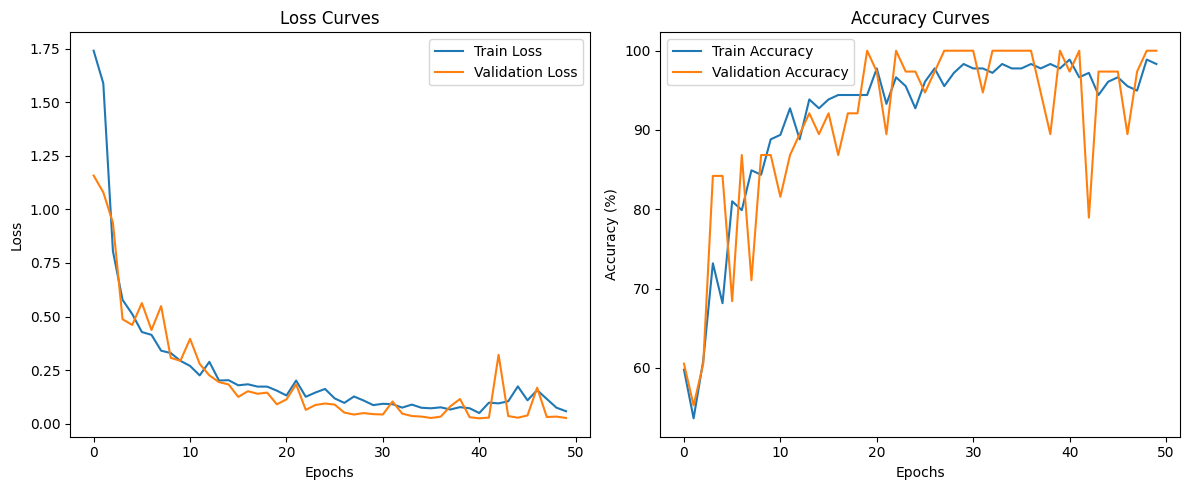

Test Accuracy: 92.31%

Classification Report:
              precision    recall  f1-score   support

  No Ellipse       0.88      1.00      0.93        21
     Ellipse       1.00      0.83      0.91        18

    accuracy                           0.92        39
   macro avg       0.94      0.92      0.92        39
weighted avg       0.93      0.92      0.92        39



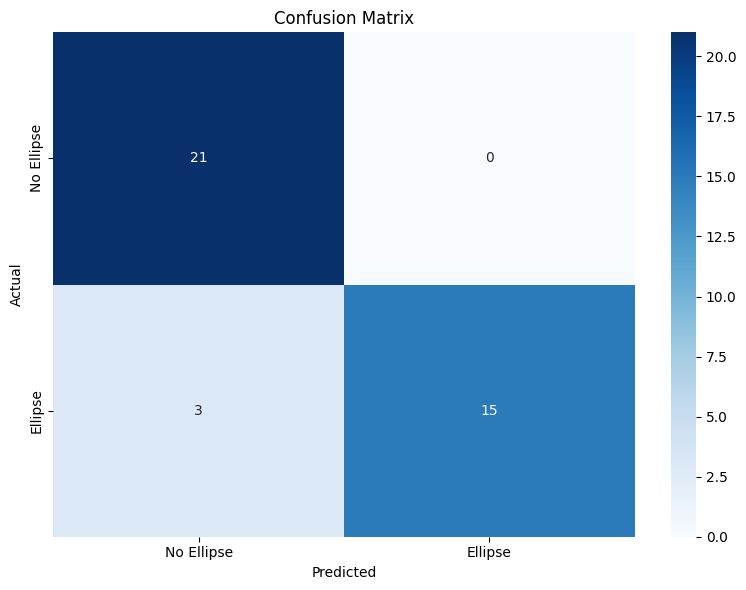

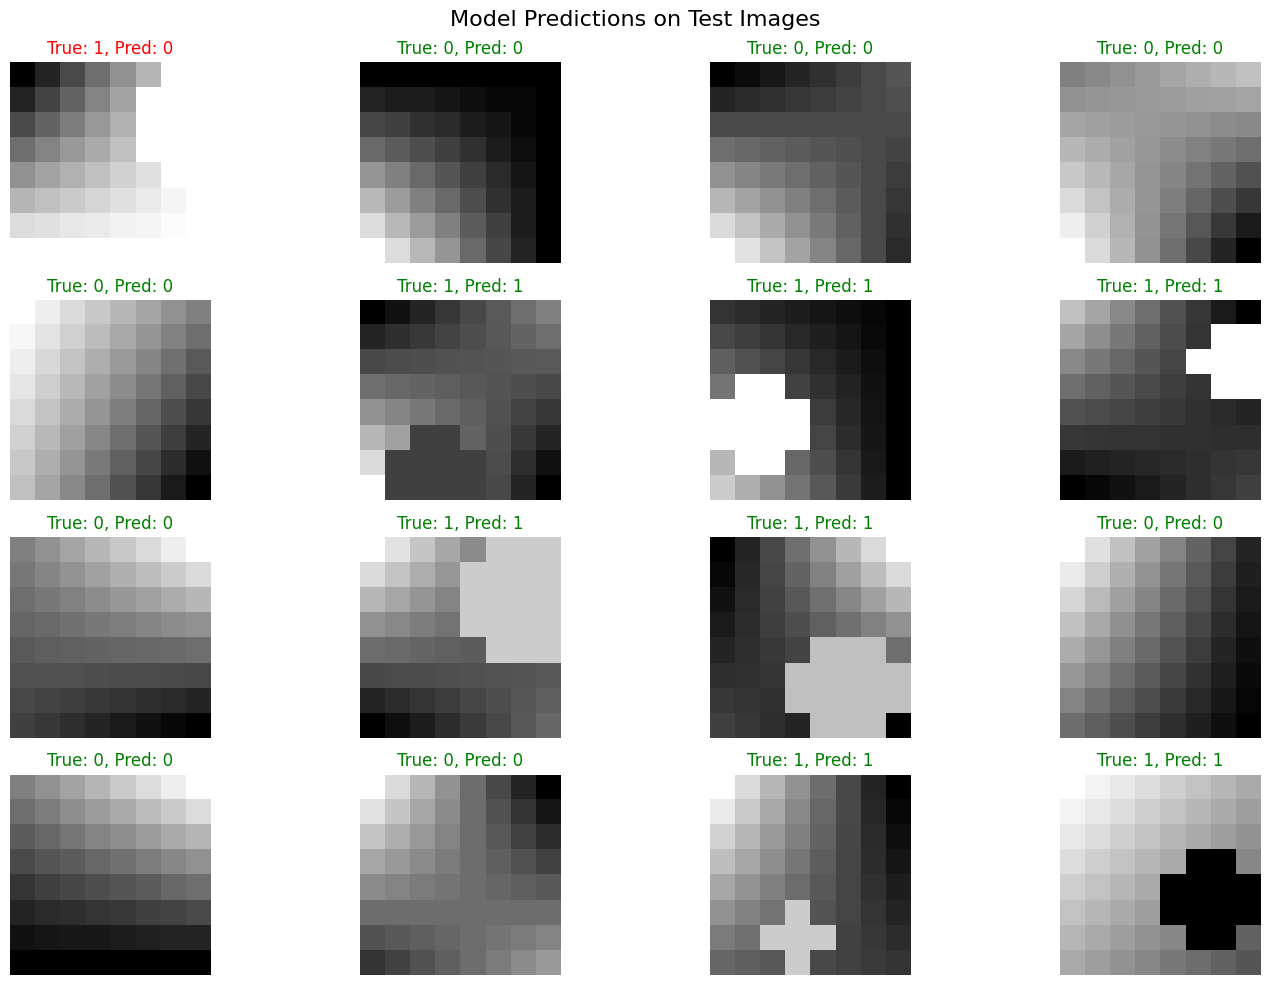

In [ ]:
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Custom Dataset
class EllipseDataset(Dataset):
    def __init__(self, data_dir, labels_file, transform=None):
        """
        Args:
            data_dir (string): Directory with all the images
            labels_file (string): Path to the CSV file with labels
            transform (callable, optional): Optional transform to be applied on a sample
        """
        self.data_dir = data_dir
        self.labels_df = pd.read_csv(labels_file)
        self.transform = transform or transforms.ToTensor()

    def __len__(self):
        return len(self.labels_df)

    def __getitem__(self, idx):
        # Load .npy file instead of image
        img_name = os.path.join(self.data_dir,
                                self.labels_df.iloc[idx, 0].replace('.jpg', '.npy'))
        image = np.load(img_name)

        # Reshape and convert to float tensor
        image = torch.FloatTensor(image).unsqueeze(0)  # Add channel dimension
        label = torch.tensor(self.labels_df.iloc[idx, 1], dtype=torch.long)

        return image, label, self.labels_df.iloc[idx, 0]

# Neural Network Model
class EllipseClassifier(nn.Module):
    def __init__(self, input_size=8):
        super(EllipseClassifier, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        # Calculate the flattened size
        self.fc_layers = nn.Sequential(
            nn.Linear(32 * 2 * 2, 64),
            nn.ReLU(),
            nn.Linear(64, 2)  # Binary classification
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)  # Flatten
        x = self.fc_layers(x)
        return x

def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=50):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    for epoch in range(num_epochs):
        # Training Phase
        model.train()
        train_loss, train_correct, train_total = 0, 0, 0

        for images, labels, _ in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()

        # Validation Phase
        model.eval()
        val_loss, val_correct, val_total = 0, 0, 0

        with torch.no_grad():
            for images, labels, _ in val_loader:
                images, labels = images.to(device), labels.to(device)

                outputs = model(images)
                loss = criterion(outputs, labels)

                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

        # Record metrics
        train_loss /= len(train_loader)
        val_loss /= len(val_loader)
        train_accuracy = 100 * train_correct / train_total
        val_accuracy = 100 * val_correct / val_total

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accuracies.append(train_accuracy)
        val_accuracies.append(val_accuracy)

        print(f'Epoch [{epoch+1}/{num_epochs}]')
        print(f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%')
        print(f'Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%')

    return model, train_losses, val_losses, train_accuracies, val_accuracies

def plot_learning_curves(train_losses, val_losses, train_accuracies, val_accuracies):
    """Plot learning curves for loss and accuracy."""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

    # Loss plot
    ax1.plot(train_losses, label='Train Loss')
    ax1.plot(val_losses, label='Validation Loss')
    ax1.set_title('Loss Curves')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.legend()

    # Accuracy plot
    ax2.plot(train_accuracies, label='Train Accuracy')
    ax2.plot(val_accuracies, label='Validation Accuracy')
    ax2.set_title('Accuracy Curves')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Accuracy (%)')
    ax2.legend()

    plt.tight_layout()
    plt.show()

def evaluate_model(model, test_loader, data_dir):
    """Comprehensive model evaluation with image visualization."""
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()

    all_preds = []
    all_labels = []

    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels, filenames in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Accuracy
    accuracy = 100 * correct / total
    print(f'Test Accuracy: {accuracy:.2f}%')

    # Classification Report
    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds,
                                target_names=['No Ellipse', 'Ellipse']))

    # Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['No Ellipse', 'Ellipse'],
                yticklabels=['No Ellipse', 'Ellipse'])
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.tight_layout()
    plt.show()

    # Image Visualization
    plt.figure(figsize=(15, 10))

    # Select a subset of images to visualize (e.g., first 16)
    num_images_to_show = min(16, len(test_loader.dataset))

    # Get test dataset
    test_dataset = test_loader.dataset

    for i in range(num_images_to_show):
        # Retrieve the image, label, and filename
        image, true_label, filename = test_dataset[i]

        # Move image to CPU and squeeze dimensions for plotting
        image_np = image.squeeze().numpy()

        # Predict
        with torch.no_grad():
            output = model(image.unsqueeze(0).to(device))
            _, predicted = torch.max(output, 1)
            predicted_label = predicted.cpu().numpy()[0]

        # Plot
        plt.subplot(4, 4, i+1)
        plt.imshow(image_np, cmap='gray')
        title = f'True: {true_label}, Pred: {predicted_label}'
        color = 'green' if true_label == predicted_label else 'red'
        plt.title(title, color=color)
        plt.axis('off')

    plt.suptitle('Model Predictions on Test Images', fontsize=16)
    plt.tight_layout()
    plt.show()

    return accuracy, all_preds, all_labels

def main():
    # Set random seed for reproducibility
    torch.manual_seed(42)
    np.random.seed(42)

    # Dataset and DataLoaders
    data_dir = "pixel_art_dataset"
    labels_file = os.path.join(data_dir, "labels.csv")

    # Create dataset
    full_dataset = EllipseDataset(data_dir, labels_file)

    # Split dataset
    train_size = int(0.7 * len(full_dataset))
    val_size = int(0.15 * len(full_dataset))
    test_size = len(full_dataset) - train_size - val_size

    train_dataset, val_dataset, test_dataset = random_split(
        full_dataset, [train_size, val_size, test_size]
    )

    # DataLoaders
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

    # Model, Loss, Optimizer
    model = EllipseClassifier()
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Train the model
    trained_model, train_losses, val_losses, train_accuracies, val_accuracies = train_model(
        model, train_loader, val_loader, criterion, optimizer
    )

    # Plot learning curves
    plot_learning_curves(train_losses, val_losses, train_accuracies, val_accuracies)

    # Evaluate the model
    accuracy, preds, labels = evaluate_model(trained_model, test_loader, data_dir)

if __name__ == "__main__":
    main()